Iteration 1
Current Storage: 1023.8908
Storage Percentage: 60.77%
Outflow (mcm/day): 0.053
Precipitation: 1.814006795, Inflow: 48.04060721
Outflow (mcm): 0.583
Next Storage (unconstrained): 1073.1624140049998
Next Storage (constrained): 1073.1624140049998
Reliability: 0.018588664421997754, Resilience: 2.0382516320474777
--------------------------------------------------
Iteration 2
Current Storage: 1073.1624140049998
Storage Percentage: 63.69%
Outflow (mcm/day): 0.053
Precipitation: 11.60436606, Inflow: 109.1598439
Outflow (mcm): 1.06
Next Storage (unconstrained): 1192.866623965
Next Storage (constrained): 1192.866623965
Reliability: 0.018588664421997754, Resilience: 2.184458201795252
--------------------------------------------------
Iteration 3
Current Storage: 1192.866623965
Storage Percentage: 70.79%
Outflow (mcm/day): 0.053
Precipitation: 23.33960005, Inflow: -65.15469405
Outflow (mcm): 0.583
Next Storage (unconstrained): 1150.4685299649998
Next Storage (constrained): 1150.4685299

/var/folders/pb/7rf69v5s2jjf1zthdkdq36rh0000gn/T/ipykernel_48647/2359011910.py:127: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DATE"] = pd.to_datetime(df["DATE"], errors='coerce')


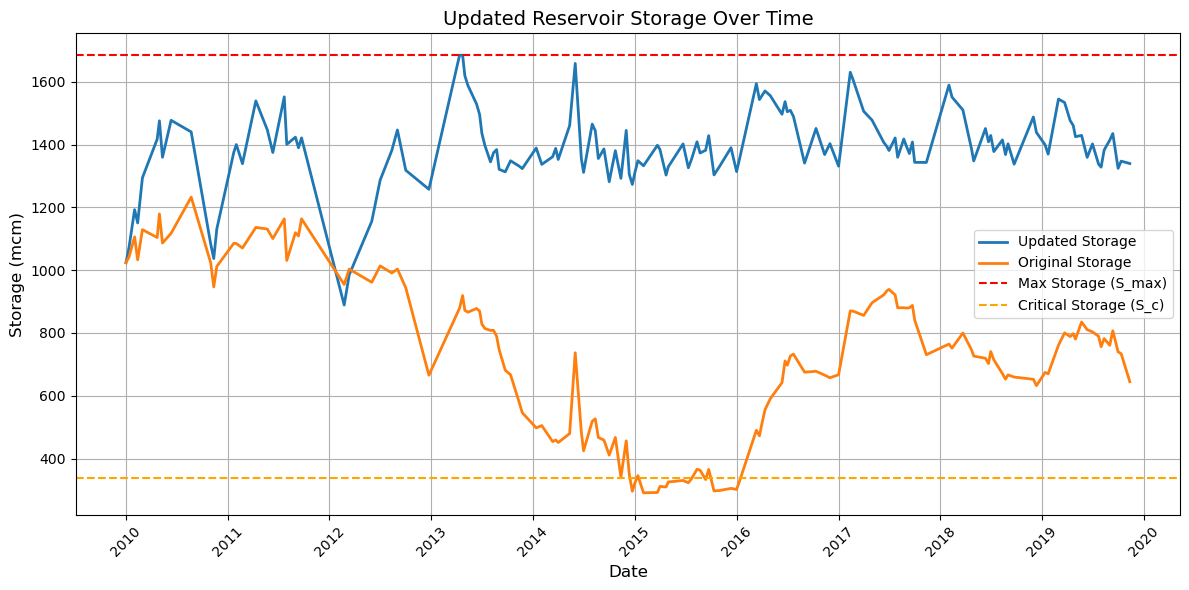

In [10]:
"""
Code we Used for Graphing the Data
Tomás Schmieder & Maoz Bizan
CEE 4200
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


file_path = '/Users/windy/desktop/data.csv'
df = pd.read_csv(file_path)

# load the dataset, which has historical values for everything
# you will need to replace the file path
file_path = '/Users/windy/desktop/data.csv'
df = pd.read_csv(file_path)

# constants
s_c = 337                       # critical storage, 20% of max
D = 2.8512                      # demand of SPMR, mcm/day
max_storage = 1685              # max storage mcm
initial_storage = 1023.8908     # intial storage mcm

def percentfull(storage, maximum_storage):
    return (storage / maximum_storage) * 100

def revised_outflow_policy(storage_percentage):
    if storage_percentage >= 82.1:
        return 4.965
    elif 38.2 <= storage_percentage < 82.1:
        return 0.053
    elif 31.6 <= storage_percentage < 31.6:
        return 2.961
    elif 10.0 <= storage_percentage < 33.0:
        return 2.678
    else:
        return 1.893

def reliability(u, D):
    return u / D

def resilience(s_t, s_c):
    return (s_t - s_c) / s_c if s_c != 0 else float('nan')  # DON'T REMOVE OR IT MIGHT BREAK, DIVIDE BY ZERO ERROR


df["Change in time (days)"] = df["Change in time (days)"].fillna(method='ffill')
df["Combined Precipitation (mcm)"] = df["Combined Precipitation (mcm)"].fillna(0)
df["Inverted Inflow (mcm)"] = df["Inverted Inflow (mcm)"].fillna(0)

# creating our datasets
current_storage = initial_storage
reliability_values = [] 
resilience_values = []  
new_storage = [initial_storage] 
new_outflow = []

# debug data will be used to print all of the data calculated at time t, you will see once you run it
debug_data = []  

# Iterate through the data
for i in range(148):  # our dataset is 149 long we need to minus 1 to account for initial and unable to get last
    # getting values
    precip = df["Combined Precipitation (mcm)"].iloc[i]
    inflow = df["Inverted Inflow (mcm)"].iloc[i]
    change_time = df["Change in time (days)"].iloc[i]
    
    # calculating stuff
    storage_percentage = percentfull(current_storage, max_storage)
    outflow = revised_outflow_policy(storage_percentage)
    new_outflow.append(outflow)
    outflow_mcm = outflow * change_time
    reliability_value = reliability(outflow, D)
    resilience_value = resilience(current_storage, s_c)

    # DEBUGGING
    print(f"Iteration {i + 1}")
    print(f"Current Storage: {current_storage}")
    print(f"Storage Percentage: {storage_percentage:.2f}%")
    print(f"Outflow (mcm/day): {outflow}")
    print(f"Precipitation: {precip}, Inflow: {inflow}")
    print(f"Outflow (mcm): {outflow_mcm}")
    print(f"Next Storage (unconstrained): {current_storage + precip + inflow - outflow_mcm}")
    print(f"Next Storage (constrained): {max(0, min(current_storage + precip + inflow - outflow_mcm, max_storage))}")
    print(f"Reliability: {reliability_value}, Resilience: {resilience_value}")
    print("-" * 50)
    debug_data.append({
        "Iteration": i + 1,
        "Current Storage": current_storage,
        "Storage Percentage": storage_percentage,
        "Outflow (mcm/day)": outflow,
        "Precipitation": precip,
        "Inflow": inflow,
        "Outflow (mcm)": outflow_mcm,
        "Next Storage": max(0, min(current_storage + precip + inflow - outflow_mcm, max_storage)),
        "Reliability": reliability_value,
        "Resilience": resilience_value,
    })

    # add to the list
    reliability_values.append(reliability_value)
    resilience_values.append(resilience_value)

    # update for next iteration
    current_storage = max(0, min(current_storage + precip + inflow - outflow_mcm, max_storage))
    new_storage.append(current_storage)

# panda better at handling then the old checker plus graph so convert it
reliability_series = pd.Series(reliability_values)
resilience_series = pd.Series(resilience_values)

# averages computed, had to make it so that we don't include bad values
reliability_average = reliability_series[~reliability_series.isna()].mean()
resilience_average = resilience_series[~resilience_series.isna()].mean()

# yes
print("Average Reliability:", reliability_average)
print("Average Resilience:", resilience_average)

# more debugging
debug_df = pd.DataFrame(debug_data)
debug_df.to_csv('/Users/windy/desktop/debug_data_corrected.csv', index=False)
print("Debug data saved to '/Users/windy/desktop/debug_data_corrected.csv'.")

# plot storage and historical storage
df["DATE"] = pd.to_datetime(df["DATE"], errors='coerce')
time_series = df["DATE"][:len(new_storage)]

plt.figure(figsize=(12, 6))
plt.plot(time_series, new_storage, label="Updated Storage", linewidth=2)
plt.plot(df["DATE"], df["Combined Storage (mcm)"], label="Original Storage", linewidth=2)

plt.axhline(y=max_storage, color='red', linestyle='--', label="Max Storage (S_max)")
plt.axhline(y=s_c, color='orange', linestyle='--', label="Critical Storage (S_c)")
plt.title("Updated Reservoir Storage Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Storage (mcm)", fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

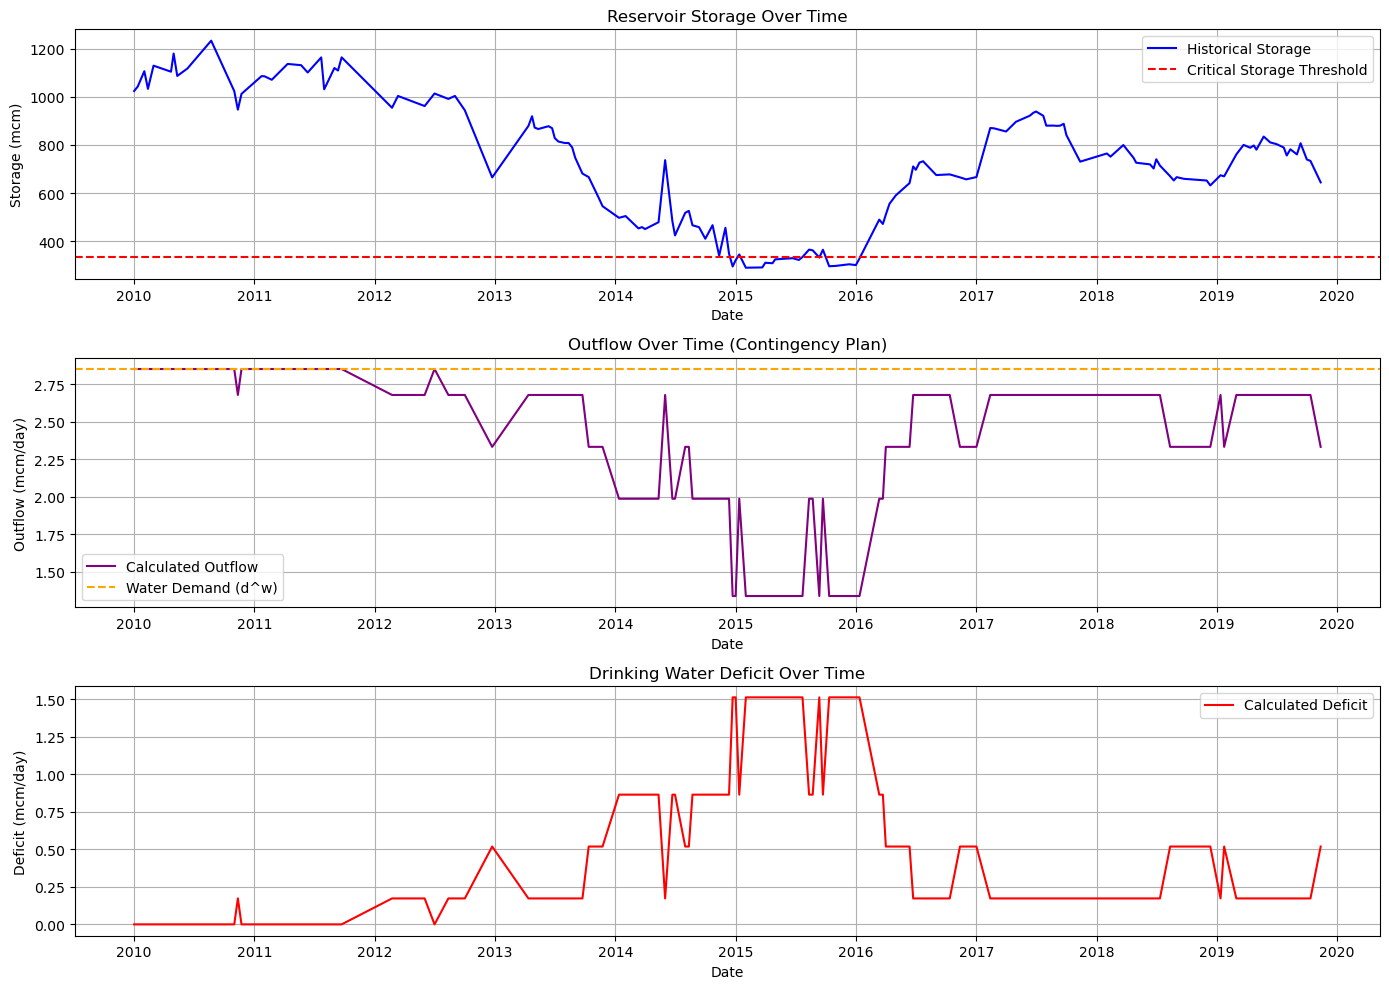

In [ ]:
# these next two blocks were originally their own code files, but we combined them so there might be some repetition
data = df
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')
data = data.dropna(subset=['DATE', 'Combined Storage (mcm)'])
data = data.sort_values('DATE').reset_index(drop=True)
storage = data['Combined Storage (mcm)'].values

S_max = 1685  
S_crit = 0.2 * S_max  
d_w = 2.8512  

# original contingency plan 
def contingency_plan(s_t):
    V_t = s_t / S_max 
    if V_t >= 0.6:
        return 2.8512
    elif 0.4 <= V_t < 0.6:
        return 2.6784
    elif 0.3 <= V_t < 0.4:
        return 2.3328
    elif 0.2 <= V_t < 0.3:
        return 1.9872
    else:
        return 1.3392

# outflow and deficit calculation
outflow = [contingency_plan(s_t) for s_t in storage]
deficit = [max(d_w - u, 0) for u in outflow]


plt.figure(figsize=(14, 10))

# storage over time
plt.subplot(3, 1, 1)
plt.plot(data['DATE'], data['Combined Storage (mcm)'], label='Historical Storage', color='blue')
plt.axhline(y=S_crit, color='red', linestyle='--', label='Critical Storage Threshold')
plt.xlabel('Date')
plt.ylabel('Storage (mcm)')
plt.title('Reservoir Storage Over Time')
plt.legend()
plt.grid(True)

# outflow over time
plt.subplot(3, 1, 2)
plt.plot(data['DATE'], outflow, label='Calculated Outflow', color='purple')
plt.axhline(y=d_w, color='orange', linestyle='--', label='Water Demand (d^w)')
plt.xlabel('Date')
plt.ylabel('Outflow (mcm/day)')
plt.title('Outflow Over Time (Contingency Plan)')
plt.legend()
plt.grid(True)

# deficit over time
plt.subplot(3, 1, 3)
plt.plot(data['DATE'], deficit, label='Calculated Deficit', color='red')
plt.xlabel('Date')
plt.ylabel('Deficit (mcm/day)')
plt.title('Drinking Water Deficit Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



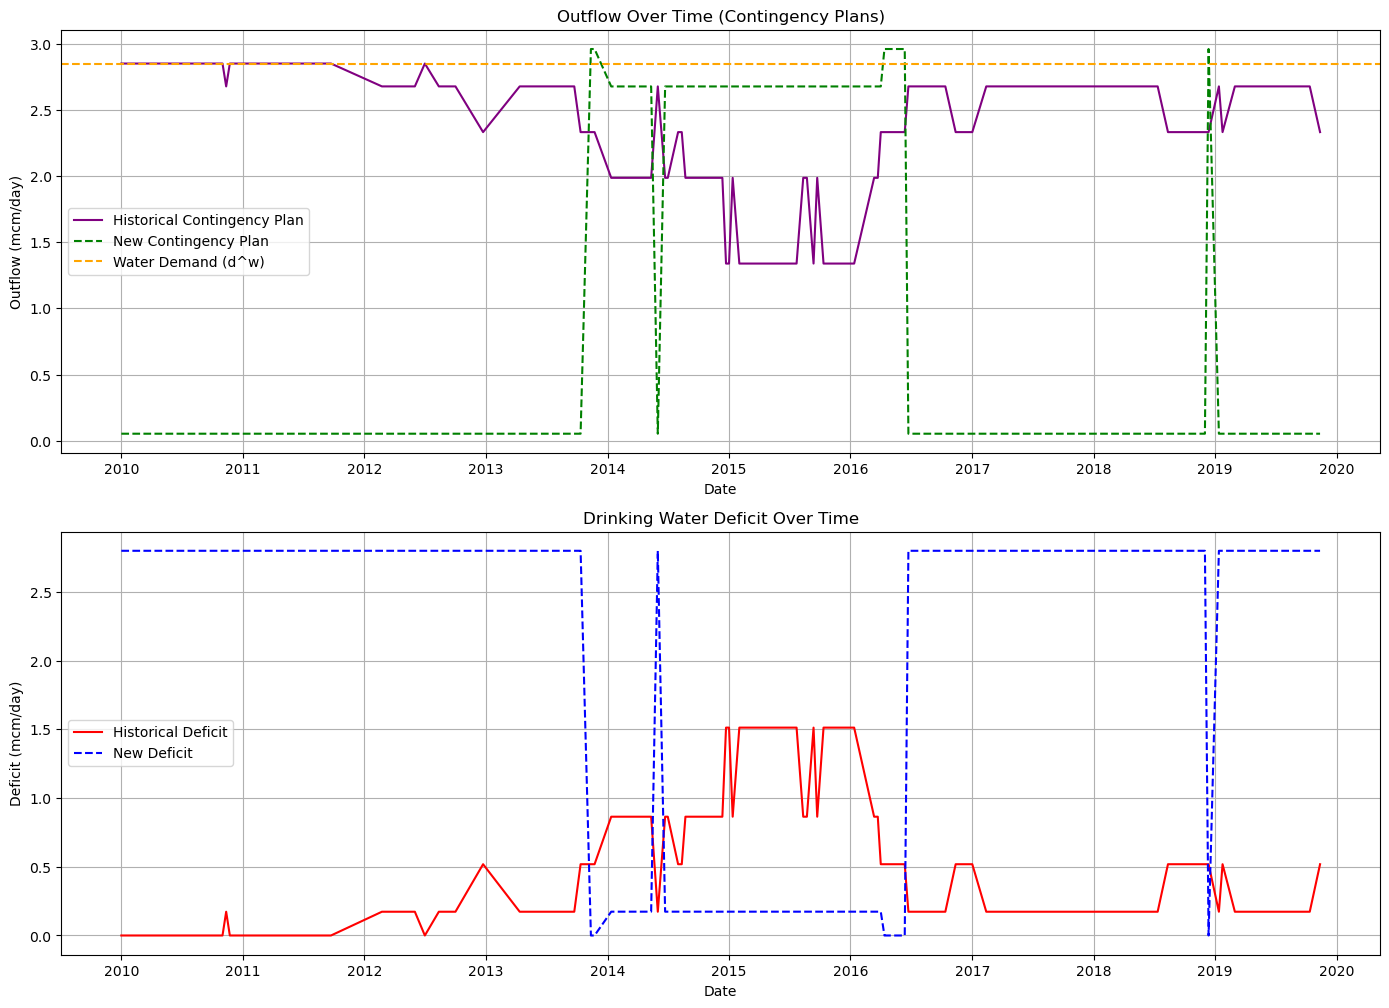

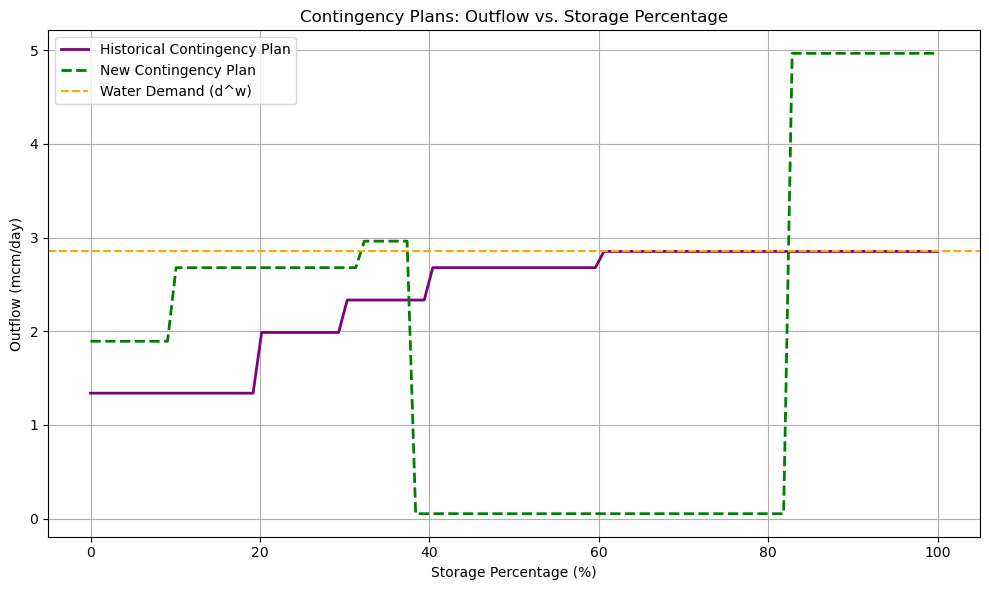

In [ ]:
# historical contingency plan
def historical_contingency_plan(s_t):
    V_t = s_t / S_max
    if V_t >= 0.6:
        return 2.8512
    elif 0.4 <= V_t < 0.6:
        return 2.6784
    elif 0.3 <= V_t < 0.4:
        return 2.3328
    elif 0.2 <= V_t < 0.3:
        return 1.9872
    else:
        return 1.3392

# new contingency plan
def new_contingency_plan(s_t):
    V_t = s_t / S_max
    if V_t >= 0.821:
        return 4.965
    elif 0.382 <= V_t < 0.821:
        return 0.053
    elif 0.316 <= V_t < 0.382:
        return 2.961
    elif 0.100 <= V_t < 0.316:
        return 2.678
    else:
        return 1.893


historical_outflow = [historical_contingency_plan(s_t) for s_t in storage]
new_outflow = [new_contingency_plan(s_t) for s_t in storage]

historical_deficit = [max(d_w - u, 0) for u in historical_outflow]
new_deficit = [max(d_w - u, 0) for u in new_outflow]


plt.figure(figsize=(14, 15))

# outflow over time
plt.subplot(3, 1, 2)
plt.plot(data['DATE'], historical_outflow, label='Historical Contingency Plan', color='purple')
plt.plot(data['DATE'], new_outflow, label='New Contingency Plan', color='green', linestyle='--')
plt.axhline(y=d_w, color='orange', linestyle='--', label='Water Demand (d^w)')
plt.xlabel('Date')
plt.ylabel('Outflow (mcm/day)')
plt.title('Outflow Over Time (Contingency Plans)')
plt.legend()
plt.grid(True)

# deficit over time
plt.subplot(3, 1, 3)
plt.plot(data['DATE'], historical_deficit, label='Historical Deficit', color='red')
plt.plot(data['DATE'], new_deficit, label='New Deficit', color='blue', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Deficit (mcm/day)')
plt.title('Drinking Water Deficit Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# dif graph that is outflow vs storage percent, dont use this one in document.
storage_percent = np.linspace(0, 1, 100)
historical_outflow_plan = [historical_contingency_plan(v * S_max) for v in storage_percent]
new_outflow_plan = [new_contingency_plan(v * S_max) for v in storage_percent]

plt.figure(figsize=(10, 6))
plt.plot(storage_percent * 100, historical_outflow_plan, label='Historical Contingency Plan', color='purple', linewidth=2)
plt.plot(storage_percent * 100, new_outflow_plan, label='New Contingency Plan', color='green', linestyle='--', linewidth=2)
plt.axhline(y=d_w, color='orange', linestyle='--', label='Water Demand (d^w)')
plt.xlabel('Storage Percentage (%)')
plt.ylabel('Outflow (mcm/day)')
plt.title('Contingency Plans: Outflow vs. Storage Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
